
**NAMA :** RIZKY EKA HARYADI  
**NIM :** 22.11.4829  
**Kelas :** Kecerdasan Buatan Lanjut 5  

**Link Datasets :** [Depression Dataset on Kaggle](https://www.kaggle.com/datasets/anthonytherrien/depression-dataset)  
**Link Google Colab :** [Google Colab Notebook](https://colab.research.google.com/drive/1ASKMuENNV17vmP-l5RYAakE9Kwoanrvb?usp=sharing)

# Deskripsi Proyek

## Problem yang Diselesaikan
Proyek ini bertujuan untuk mendeteksi kemungkinan seseorang mengalami depresi berdasarkan data tertentu, seperti riwayat kesehatan mental, gaya hidup, dan faktor lainnya. Hal ini penting untuk memberikan intervensi dini dan mengurangi risiko komplikasi serius akibat depresi.

## Fakta atau Pernyataan Pendukung Problem
1. Menurut WHO (World Health Organization), lebih dari 264 juta orang di seluruh dunia menderita depresi. ([https://www.who.int/news-room/fact-sheets/detail/depression](https://www.who.int/news-room/fact-sheets/detail/depression))
2. Studi dalam jurnal "The Lancet Psychiatry" menunjukkan bahwa deteksi dini depresi dapat meningkatkan peluang pemulihan hingga 80%. ([https://www.thelancet.com/journals/lanpsy/home](https://www.thelancet.com/journals/lanpsy/home))
3. Data dari Badan Pusat Statistik (BPS) menunjukkan peningkatan prevalensi masalah kesehatan mental di Indonesia sebesar 7% dalam lima tahun terakhir. ([https://www.bps.go.id/](https://www.bps.go.id/))

## Keterangan Dataset
Dataset yang digunakan mencakup data anonim individu dengan berbagai atribut, seperti:
- **Riwayat kesehatan mental** (contoh: apakah pernah mengalami masalah kesehatan mental sebelumnya).
- **Faktor gaya hidup** (contoh: kebiasaan olahraga, pola tidur).
- **Demografi** (contoh: usia, jenis kelamin).
Dataset ini diproses dengan teknik seperti *one-hot encoding*, normalisasi, dan pembagian menjadi data pelatihan dan uji.

## Model dan Konfigurasi yang Digunakan
Model yang digunakan adalah LSTM (Long Short-Term Memory), yang dirancang untuk memahami data berurutan. Konfigurasi utama:
- Dua lapisan LSTM dengan 64 dan 32 unit masing-masing.
- Fungsi aktivasi **ReLU** pada lapisan tersembunyi dan **sigmoid** pada lapisan output.
- Optimizer **Adam** dengan fungsi loss **binary crossentropy**.
- Pelatihan dilakukan dengan K-Fold Cross-Validation (2 lipatan).

## Metrik Pengukuran Performa
- **Akurasi**: Mengukur persentase prediksi yang benar.
- **Confusion Matrix**: Untuk melihat distribusi prediksi benar dan salah, termasuk True Positive, False Positive, True Negative, dan False Negative.
- **Loss**: Mengukur kesalahan prediksi selama pelatihan.



### **Cell 1: Setup dan Unduh Dataset**

In [ ]:
# Import library yang diperlukan
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Unduh dataset
path = kagglehub.dataset_download("anthonytherrien/depression-dataset")
print("Dataset berhasil diunduh.")
print(f"Lokasi file dataset: {path}")

Dataset berhasil diunduh.
Lokasi file dataset: /root/.cache/kagglehub/datasets/anthonytherrien/depression-dataset/versions/1


### **Cell 2: Muat dan Lakukan Preprocessing Dataset**

In [ ]:
# Muat dataset
data = pd.read_csv(f"{path}/depression_data.csv")
print("Dataset berhasil dimuat. 5 baris pertama:")
print(data.head())

# Preprocessing
features = data.drop(columns=['Name'])
features = pd.get_dummies(features)  # One-hot encoding
labels = data['History of Mental Illness'].apply(lambda x: 1 if x == 'Yes' else 0).values
features.fillna(features.mean(), inplace=True)
print("Preprocessing selesai. Dimensi fitur:", features.shape)

Dataset berhasil dimuat. 5 baris pertama:
               Name  Age Marital Status    Education Level  \
0  Christine Barker   31        Married  Bachelor's Degree   
1  Jacqueline Lewis   55        Married        High School   
2    Shannon Church   78        Widowed    Master's Degree   
3    Charles Jordan   58       Divorced    Master's Degree   
4      Michael Rich   18         Single        High School   

   Number of Children Smoking Status Physical Activity Level  \
0                   2     Non-smoker                  Active   
1                   1     Non-smoker               Sedentary   
2                   1     Non-smoker               Sedentary   
3                   3     Non-smoker                Moderate   
4                   0     Non-smoker               Sedentary   

  Employment Status     Income Alcohol Consumption Dietary Habits  \
0        Unemployed   26265.67            Moderate       Moderate   
1          Employed   42710.36                High      Unheal

### **Cell 3: Bagi Dataset dan Normalisasi**

In [ ]:
# Bagi dataset
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Normalisasi fitur
train_features = train_features.astype('float32') / train_features.max().astype('float32')
test_features = test_features.astype('float32') / test_features.max().astype('float32')

# Bentuk ulang data untuk LSTM
train_features = train_features.values.reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = test_features.values.reshape((test_features.shape[0], 1, test_features.shape[1]))
print("Data diubah bentuk untuk LSTM. Dimensi fitur pelatihan:", train_features.shape)

Data diubah bentuk untuk LSTM. Dimensi fitur pelatihan: (331014, 1, 37)


### **Cell 4: Bangun Model LSTM**

In [ ]:
# Bangun model LSTM
input_layer = layers.Input(shape=(train_features.shape[1], train_features.shape[2]))
x = layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
x = layers.LSTM(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model LSTM berhasil dibangun dan dikompilasi.")

Model LSTM berhasil dibangun dan dikompilasi.


### **Cell 5: Latih Model dengan K-Fold**

In [ ]:
from sklearn.model_selection import KFold

# Tambahkan checkpoint
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Latih model dengan K-Fold
kf = KFold(n_splits=2)
histories = []
fold = 1
for train_index, val_index in kf.split(train_features):
    print(f"Melatih fold {fold}...")
    x_train, x_val = train_features[train_index], train_features[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    history = model.fit(x_train, y_train, epochs=3, validation_data=(x_val, y_val), callbacks=[checkpoint])
    histories.append(history)
    fold += 1

# Muat model terbaik
model = keras.models.load_model('best_model.keras')
print("Model terbaik berhasil dimuat dari checkpoint.")

Melatih fold 1...
Epoch 1/3
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9723 - loss: 0.0539 - val_accuracy: 1.0000 - val_loss: 5.8020e-08
Epoch 2/3
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 1.0000 - loss: 3.2880e-08 - val_accuracy: 1.0000 - val_loss: 6.5985e-09
Epoch 3/3
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 1.0000 - loss: 5.7490e-09 - val_accuracy: 1.0000 - val_loss: 4.6602e-09
Melatih fold 2...
Epoch 1/3
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 1.0000 - loss: 4.5635e-09 - val_accuracy: 1.0000 - val_loss: 4.3834e-09
Epoch 2/3
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 1.0000 - loss: 4.3684e-09 - val_accuracy: 1.0000 - val_loss: 4.1791e-09
Epoch 3/3
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 1.0000 - loss: 4.2363e-09 - val_accuracy: 1.0000 - val_loss: 4.2291e-09
Model terbaik berhasil dimuat dari checkpoint.


### **Cell 6: Evaluasi Model**

In [ ]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Evaluasi selesai. Akurasi pada data uji: {test_acc:.4f}")

2587/2587 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 5.8350e-08
Evaluasi selesai. Akurasi pada data uji: 1.0000


###**Cell 7: Visualisasi Riwayat Pelatihan**

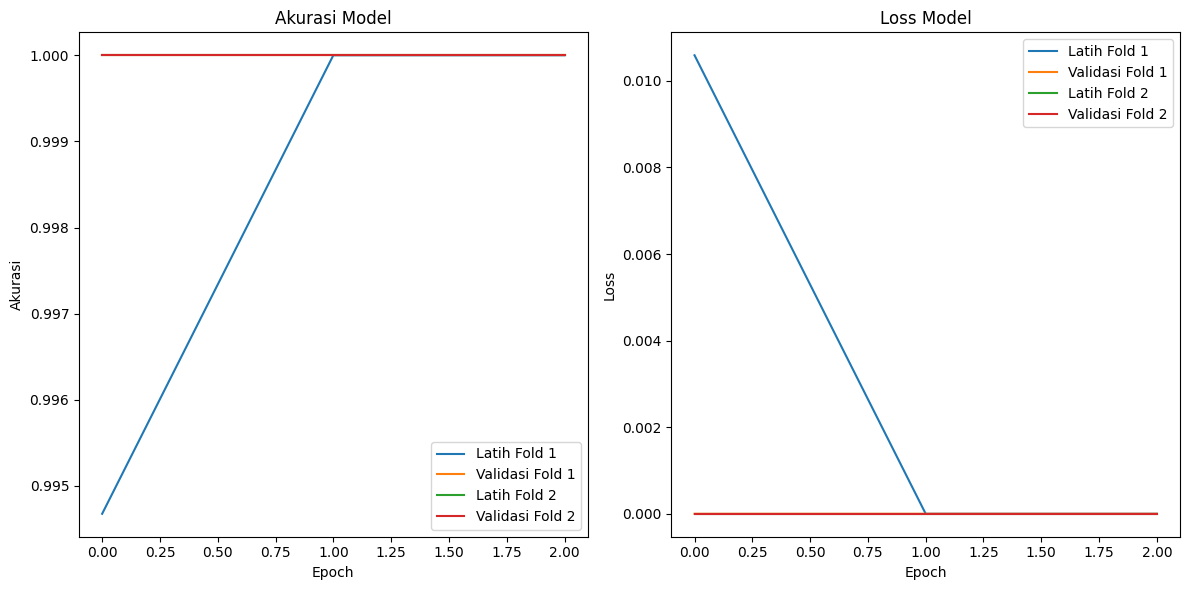

In [ ]:
# Visualisasi riwayat pelatihan
def plot_training_history(histories):
    plt.figure(figsize=(12, 6))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'Latih Fold {i+1}')
        plt.plot(history.history['val_accuracy'], label=f'Validasi Fold {i+1}')
    plt.title('Akurasi Model')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'Latih Fold {i+1}')
        plt.plot(history.history['val_loss'], label=f'Validasi Fold {i+1}')
    plt.title('Loss Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(histories)

### **Cell 8: Visualisasi Tambahan**

2587/2587 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


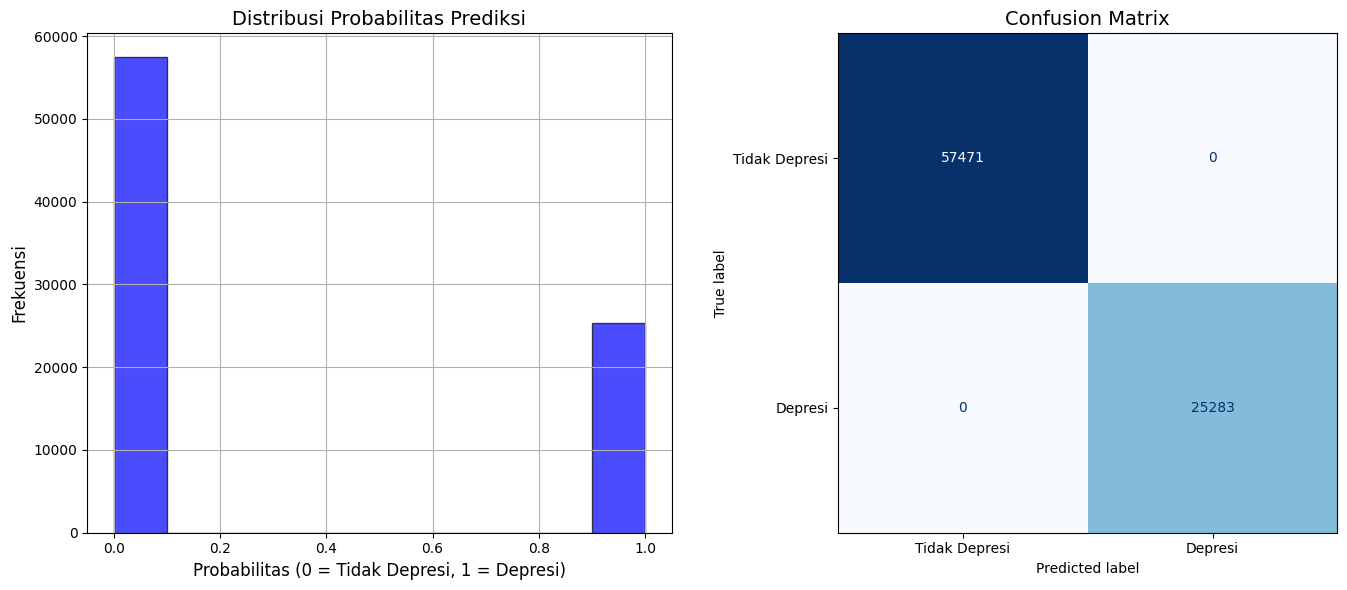

In [ ]:
# Prediksi probabilitas
predictions = model.predict(test_features)

# Membuat subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Distribusi Probabilitas Prediksi
axes[0].hist(predictions, bins=10, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribusi Probabilitas Prediksi', fontsize=14)
axes[0].set_xlabel('Probabilitas (0 = Tidak Depresi, 1 = Depresi)', fontsize=12)
axes[0].set_ylabel('Frekuensi', fontsize=12)
axes[0].grid(True)

# Subplot 2: Confusion Matrix
test_pred_classes = (predictions >= 0.5).astype(int)
cm = confusion_matrix(test_labels, test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Depresi', 'Depresi'])
disp.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title('Confusion Matrix', fontsize=14)

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()

### **Cell 9 : SHAP**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


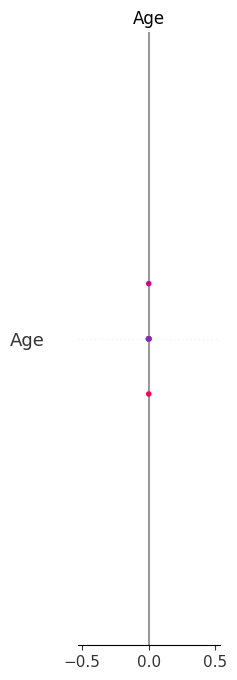

In [ ]:
# SHAP summary plot
import shap

# Ratakan data menjadi 2D untuk SHAP
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Fungsi pembungkus untuk prediksi
def wrapped_predict(data):
    # Ubah data kembali ke 3D sebelum digunakan oleh model
    reshaped_data = data.reshape(data.shape[0], 1, -1)
    return model.predict(reshaped_data)

# Inisialisasi KernelExplainer dengan pembungkus fungsi prediksi
explainer = shap.KernelExplainer(wrapped_predict, train_features_flat[:100])

# Hitung SHAP values untuk data uji yang diratakan
shap_values = explainer.shap_values(test_features_flat[:10])

# Visualisasi SHAP summary plot
shap.summary_plot(shap_values, test_features_flat[:10], feature_names=features.columns)

### **Cell 10: Prediksi Statis**

In [ ]:
# Ambil beberapa sampel dari data uji (test_features)
sample_data = test_features[:5]  # Menggunakan 5 sampel pertama sebagai contoh

# Lakukan prediksi menggunakan model
static_predictions = model.predict(sample_data)

# Tampilkan hasil prediksi dalam format yang mudah dipahami
print("Prediksi Statis:\n")
for i, prediction in enumerate(static_predictions, start=1):
    status = "Depresi" if prediction[0] >= 0.5 else "Tidak Depresi"
    print(f"Sampel {i}:")
    print(f"  Probabilitas Depresi: {prediction[0]:.4f}")
    print(f"  Prediksi Kelas: {status}\n")

# Contoh tambahan: Jika ingin menampilkan sebagai tabel menggunakan pandas
def display_predictions(data, predictions):
    import pandas as pd

    result = pd.DataFrame({
        "Sampel": [f"Sampel {i+1}" for i in range(len(data))],
        "Probabilitas Depresi": [pred[0] for pred in predictions],
        "Kelas": ["Depresi" if pred[0] >= 0.5 else "Tidak Depresi" for pred in predictions]
    })
    return result

# Tampilkan prediksi dalam bentuk tabel
prediction_table = display_predictions(sample_data, static_predictions)
print(prediction_table)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediksi Statis:

Sampel 1:
  Probabilitas Depresi: 0.0000
  Prediksi Kelas: Tidak Depresi

Sampel 2:
  Probabilitas Depresi: 1.0000
  Prediksi Kelas: Depresi

Sampel 3:
  Probabilitas Depresi: 0.0000
  Prediksi Kelas: Tidak Depresi

Sampel 4:
  Probabilitas Depresi: 0.0000
  Prediksi Kelas: Tidak Depresi

Sampel 5:
  Probabilitas Depresi: 1.0000
  Prediksi Kelas: Depresi

     Sampel  Probabilitas Depresi          Kelas
0  Sampel 1          2.497820e-08  Tidak Depresi
1  Sampel 2          1.000000e+00        Depresi
2  Sampel 3          1.156932e-07  Tidak Depresi
3  Sampel 4          9.662229e-08  Tidak Depresi
4  Sampel 5          9.999998e-01        Depresi
